# Value at Risk

_The only constant in life is change_ - Heraclitus

Value at Risk (VaR) is a widely used risk measure in financial risk management that quantifies the potential loss in a portfolio over a given time period with a specified confidence level. However, VaR has limitations, including its inability to capture the severity of losses beyond its threshold. To address this, alternative measures such as Expected Shortfall (ES) have been introduced. We explore different methodologies for calculating VaR, including parametric, historical, and Monte Carlo simulation approaches, as well as advanced techniques such as stressed VaR and bootstrapping. Additionally, we examine conditional volatility models, including EWMA and GARCH, to account for changing market conditions. Finally, we discuss backtesting methods, such as the Kupiec Likelihood Ratio test and conditional coverage tests, to validate the accuracy of VaR models in real-world scenarios.


In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
from typing import Dict
import numpy as np
from scipy import stats
import pandas as pd
from pandas import DataFrame, Series
import statsmodels.api as sm
import matplotlib.pyplot as plt
from finds.readers import Alfred
from finds.utils import row_formatted
from secret import credentials
#pd.set_option('display.max_rows', None)
VERBOSE = 0
#%matplotlib qt

## Risk measures

**Value at Risk (VaR)** is a fundamental risk measure that estimates the maximum potential loss in a portfolio over a specific period at a given confidence level. A VaR at an \(\alpha\%\) confidence level represents the loss threshold that has an \(\alpha\%\) probability of being exceeded.  


### Coherence

A major limitation of VaR is that it does not provide insight into the magnitude of losses beyond its threshold. Artzner et al. proposed four essential properties that a risk measure should satisfy:  

1. **Monotonicity:** If one portfolio consistently performs worse than another under all conditions, it should have a higher risk measure.  
2. **Translation Invariance:** Adding a risk-free cash amount $K$ to a portfolio should reduce its risk measure by $K$.  
3. **Homogeneity:** Scaling a portfolio by a factor of $X$ should scale its risk measure by the same factor.  
4. **Subadditivity:** The risk measure of a merged portfolio should not exceed the sum of the individual risk measures, ensuring diversification benefits.  

A risk measure that satisfies all four properties is considered **coherent**. **Expected Shortfall (ES)** is a coherent risk measure, whereas VaR lacks subadditivity. ES is calculated as the probability-weighted average of losses beyond the VaR threshold. Other coherent risk measures can be derived by applying a risk aversion function to weight quantiles, with ES being a special case where tail quantiles receive equal weighting.  


Retrieve crypto currency index returns from FRED

In [31]:
# retrieve crypto currency index from FRED, as log returns
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE, convert_date=0)
cat = alf.get_category(33913)
cryptos = [alf(s['id'], log=1, diff=1)
           for s in cat['series'] if 'DISCONT' not in s['title']]
cryptos = pd.concat(cryptos, axis=1).sort_index()
date_str = f" ({str(cryptos.index[0])[:10]} to {str(cryptos.index[-1])[:10]})"
titles = Series({s['id']: s['title']
                 for s in cat['series'] if 'DISCONT' not in s['title']},
                name=cat['name'])

In [32]:
# crypto index names
titles.to_frame().rename_axis(index=cat['id'])

,Cryptocurrencies
33913,
CBBCHUSD,Coinbase Bitcoin Cash
CBBTCUSD,Coinbase Bitcoin
CBETHUSD,Coinbase Ethereum
CBLTCUSD,Coinbase Litecoin


In [34]:
# recent crypto log returns
cryptos

,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
date,,,,
2014-12-01,NaN,NaN,NaN,NaN
2014-12-02,NaN,0.021391,NaN,NaN
2014-12-03,NaN,0.000000,NaN,NaN
2014-12-04,NaN,-0.002384,NaN,NaN
2014-12-06,NaN,0.002384,NaN,NaN
...,...,...,...,...
2025-02-26,0.010099,0.006085,-0.011953,0.018231
2025-02-27,0.062384,-0.003877,-0.030322,0.009735
2025-02-28,-0.014295,0.020210,-0.008916,-0.029413


### Parametric method

Assuming returns follow a normal distribution, VaR and ES at a confidence level $\alpha$ are given by:  

$$
VaR = -\mu + \sigma z_{1-\alpha}
$$

$$
ES = -\mu + \sigma \dfrac{\exp(-z_{1-\alpha}^2/2)}{(1 - \alpha)\sqrt{2 \pi}}
$$

where $ z_{\alpha} $ is the standard normal quantile corresponding to $\alpha$.  

For example, at a 95% confidence level ($\alpha = 0.95$), $ z_{\alpha} = -1.645 $, which represents the lower 5% quantile. In practice, $\mu$ and $\sigma$ are estimated from historical data, but since short-term mean returns are difficult to measure accurately, $\mu$ is often assumed to be zero.  

Under the assumption that geometric returns are normally distributed, then arithmetic returns follow a __lognormal distribution__. The skewness of the lognormal $(\exp(\sigma^2) + 2)\sqrt{(\exp(\sigma^2) - 1)}$ is always positive, hence the lognormal has a long right-tail. The lognormal has kurtosis
$\exp(\sigma^2)^4 + 2\exp(\sigma^2)^3 + 3\exp(\sigma^2)^2 -3$ which exceeds 3 and increases with volatility, hence exhibits fatter tails than the normal distribution.



In [35]:
# Helper to compute parametric VaR and ES
def parametric_risk(sigma: float | Series, alpha: float) -> Dict:
    """Calculate parametric gaussian VaR and ES"""
    var = -sigma * stats.norm.ppf(1 - alpha)
    es = sigma * stats.norm.pdf(stats.norm.ppf(1 - alpha)) / (1 - alpha)
    return dict(value_at_risk=var, expected_shortfall=es)

In [36]:
alpha = 0.95
volatility = {label: np.std(cryptos[label]) for label in cryptos}
parametric = DataFrame({label: Series(parametric_risk(std, alpha=alpha))
                        for label, std in volatility.items()})
print(f"Parametric Risk Measures (alpha={alpha})")
pd.concat([DataFrame.from_dict({'volatility': volatility}, orient='index'),
           parametric], axis=0).round(4)

Parametric Risk Measures (alpha=0.95)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
volatility,0.0576,0.0396,0.0505,0.0543
value_at_risk,0.0948,0.0651,0.0831,0.0894
expected_shortfall,0.1189,0.0817,0.1042,0.1121


### Delta-Normal method

The delta-normal method provides an approximation for non-linear portfolios by assuming that underlying asset returns are normally distributed. The risk of the portfolio is modeled using **delta**, which measures the sensitivity of portfolio value to changes in underlying asset prices. A more refined approximation includes **gamma**, the second derivative of portfolio value with respect to asset prices, known as the **delta-gamma method**.  



### Monte Carlo simulation method


Monte Carlo simulation applies to both linear and non-linear portfolios. This approach generates random scenarios based on an assumed distribution for underlying risk factors. If 1,000 scenarios are simulated, the 95% VaR is estimated as the 50th worst loss (i.e., the 5th percentile), while Expected Shortfall is calculated as the average of the 49 worst losses.  

However, standard Monte Carlo models assume normality and independence, which may not always reflect real-world financial data, necessitating the use of **non-parametric approaches**.  

A **QQ plot** compares the empirical distribution of returns to a theoretical normal distribution. If returns exhibit heavier tails than the reference distribution, the QQ plot will have steeper slopes at the extremes.  


/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


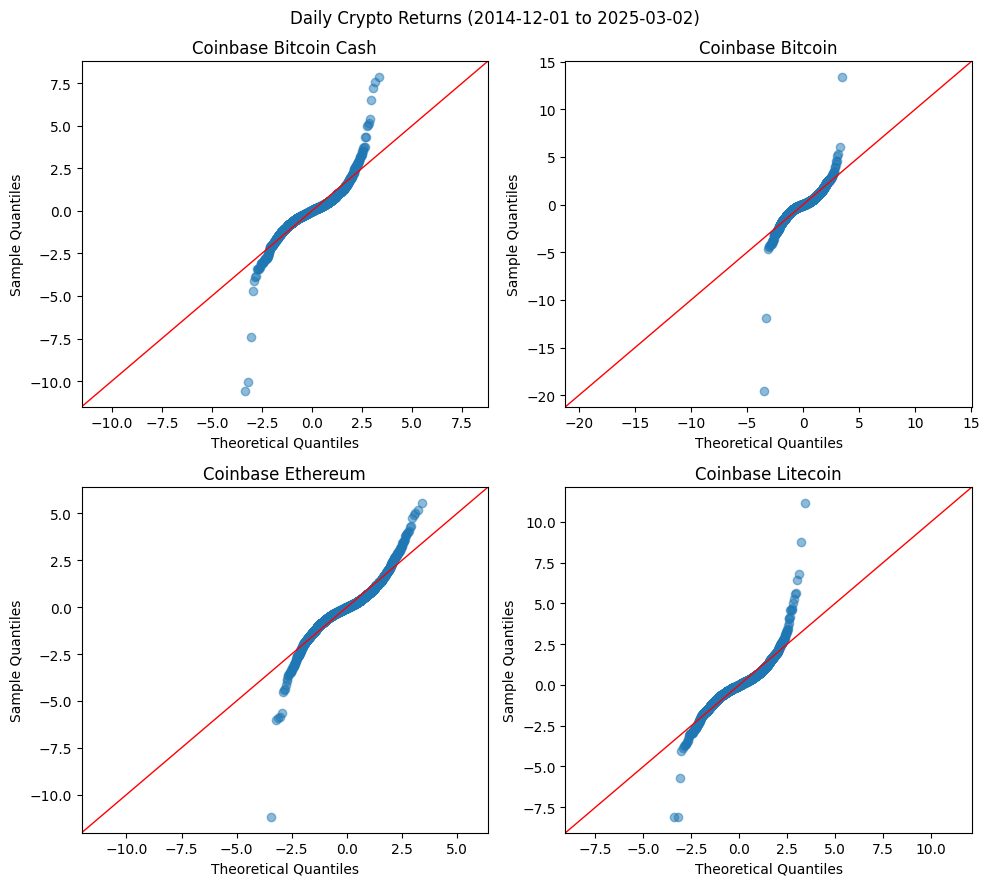

In [61]:
# QQ Plot for Gaussian assumption
from statsmodels.graphics.gofplots import ProbPlot
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    pp = ProbPlot(cryptos[label].dropna(), fit=True)
    pp.qqplot(ax=ax, color='C0', alpha=.5)
    sm.qqline(ax=ax, fmt='r--', line='45', lw=1)
    ax.set_title(f"{titles[label]}")
plt.suptitle(f"Daily Crypto Returns" + date_str)
plt.tight_layout()

Lag plot of daily returns

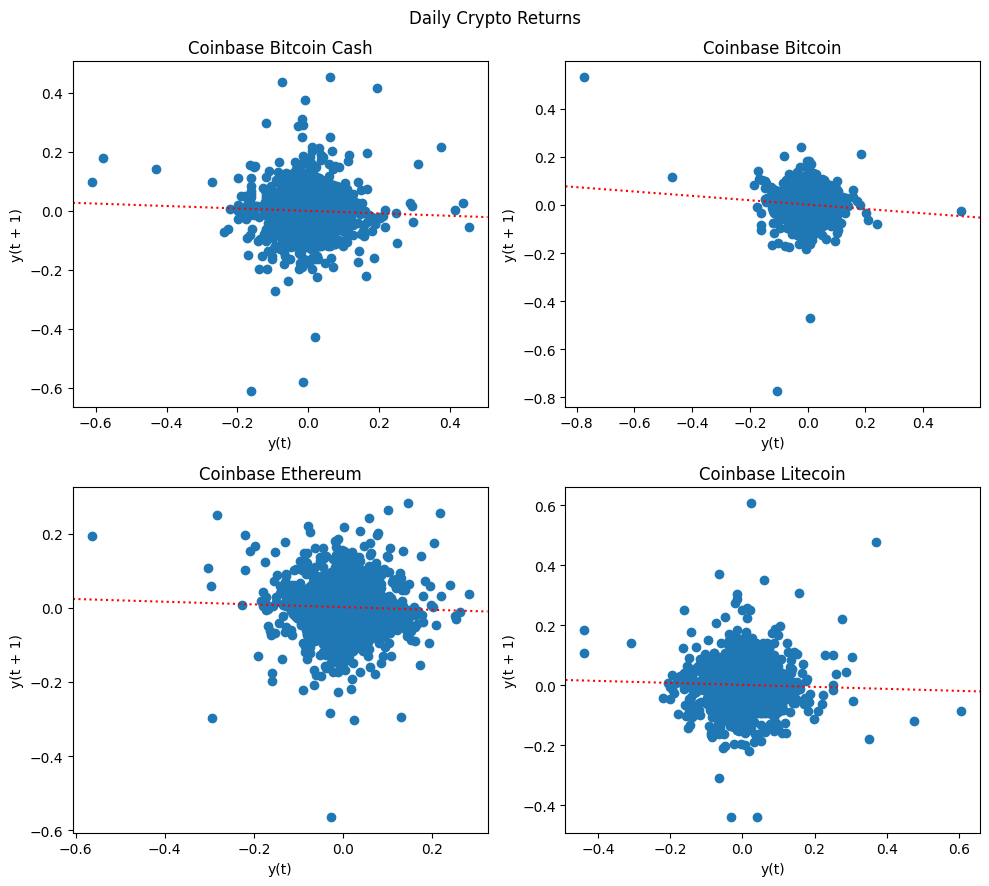

In [38]:
# Autocorrelation of returns
import statsmodels.api as sm
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    X = cryptos[label].dropna()
    pd.plotting.lag_plot(X, lag=1, ax=ax)
    r = stats.linregress(X.values[1:], X.values[:-1])
    ax.axline((0, r.intercept), slope=r.slope, ls=':', color="red")    
    ax.set_title(f"{titles[label]}")
plt.suptitle(f"Daily Crypto Returns")
plt.tight_layout()

Lag plot of squared daily returns

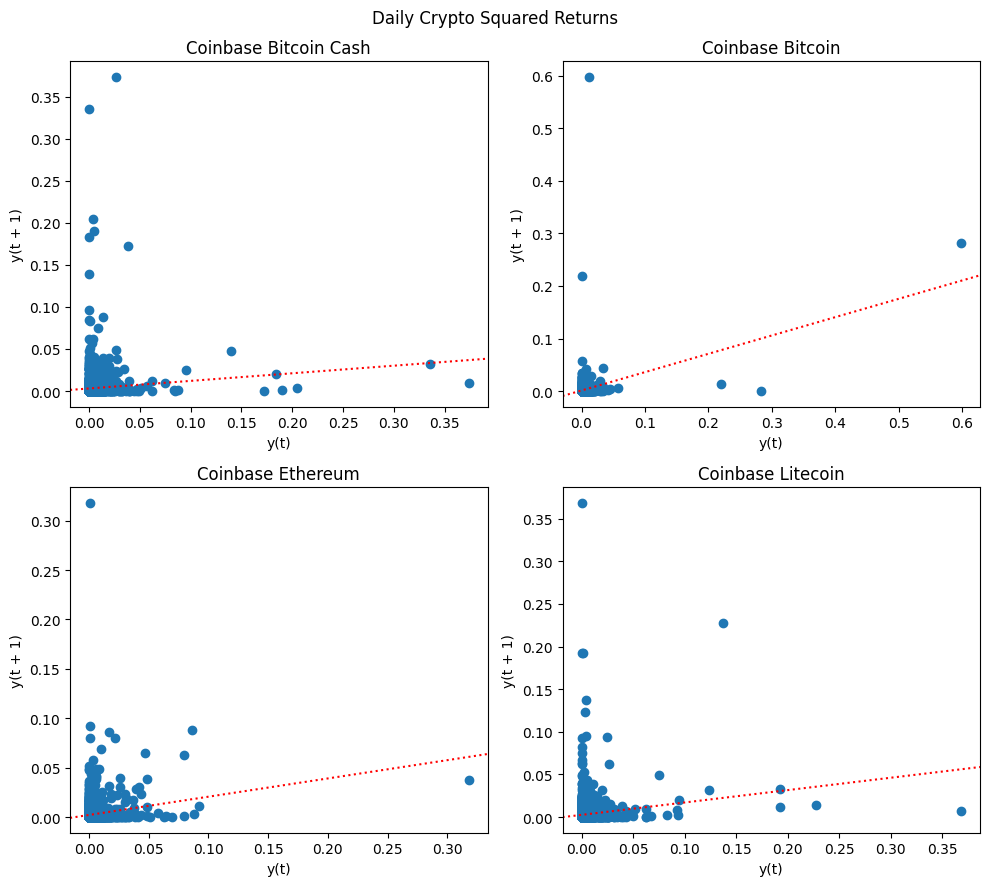

In [39]:
# Autocorrelation of squared returns
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    X = cryptos[label].dropna()**2
    pd.plotting.lag_plot(X, lag=1, ax=ax)
    r = stats.linregress(X.values[1:], X.values[:-1])
    ax.axline((0, r.intercept), slope=r.slope, ls=':', color="red")    
    ax.set_title(f"{titles[label]}")
plt.suptitle(f"Daily Crypto Squared Returns")
plt.tight_layout()

### Historical Simulation method

**Historical simulation (HS)** is the simplest non-parametric approach that estimates VaR by ordering historical losses and selecting the appropriate quantile. Expected Shortfall is calculated as the average of losses beyond the VaR threshold. This method accommodates non-normal features such as skewness and fat tails, making it robust in capturing market risks. However, its accuracy depends on whether the historical dataset adequately represents future market conditions.  




In [40]:
# Helper to compute VaR, ES and sample moments from historical simulation
def historical_risk(X: Series, alpha: float):
    """Calculate historical VaR, ES, and sample moments"""
    X = X.dropna()
    N = len(X)
    var = -np.percentile(X, 100 * (1 - alpha))
    es = -np.mean(X[X < var])
    vol = np.std(X, ddof=0)
    skew = stats.skew(X)
    kurt = stats.kurtosis(X)
    jb = stats.jarque_bera(X)[0]
    jbp = stats.jarque_bera(X)[1]
    return dict(N=N, value_at_risk=var, expected_shortfall=es, volatility=vol,
                skewness=skew, excess_kurtosis=kurt-3, jb_statistic=jb, jb_pvalue=jbp)

In [41]:
hist = DataFrame({label: historical_risk(cryptos[label], alpha=alpha)
                  for label in cryptos})
print(f"Historical Risk Measures (alpha={alpha})")
row_formatted(hist.round(4), {'N': "{:.0f}"})

Historical Risk Measures (alpha=0.95)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
N,2623,3709,3207,3117
value_at_risk,0.0831,0.0583,0.074,0.0822
expected_shortfall,0.0078,0.0032,0.0055,0.0061
volatility,0.0576,0.0396,0.0505,0.0543
skewness,-0.2394,-1.822,-0.4136,0.7306
excess_kurtosis,13.159,52.3855,6.0638,10.3101
jb_statistic,28562.5232,476116.6693,11069.1899,23285.8936
jb_pvalue,0.0,0.0,0.0,0.0


### Stressed VaR method

During periods of market stress, volatility and correlations tend to rise, often leading to *correlation breakdowns* where asset prices move more synchronously. It is sometimes stated that "in stressed markets all correlations go to one." Standard VaR models may not capture these dynamics accurately.  **Stressed VaR** is calculated using historical periods of extreme market distress, such as the 2008 Financial Crisis or the 2021–2022 Crypto Winter, as opposed to simply the most recent number of years. Stress testing is designed to identify vulnerabilities, particularly those involving periods of high volatility.

In [42]:
beg, end = '2021-11-01', '2022-11-21'  # dubbed "crypto winter"
stress = DataFrame({label: historical_risk(cryptos.loc[beg:end, label], alpha=alpha)
                    for label in cryptos})
print(f"Stressed Risk Measures ({beg} to {end})")
row_formatted(stress.round(4).rename_axis(index='(alpha=0.05)'), {'N': "{:.0f}"})

Stressed Risk Measures (2021-11-01 to 2022-11-21)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
(alpha=0.05),,,,
N,386,386,386,386
value_at_risk,0.0818,0.0624,0.0773,0.0911
expected_shortfall,0.0078,0.0058,0.0074,0.0053
volatility,0.0464,0.0348,0.0461,0.0478
skewness,-0.3194,-0.5904,-0.3785,-0.417
excess_kurtosis,-0.5048,0.7985,-0.6065,-1.0258
jb_statistic,106.6976,254.4822,101.3559,73.8708
jb_pvalue,0.0,0.0,0.0,0.0


### Bootstrap method

**Bootstrap resampling** improves historical simulation by repeatedly drawing random samples from the dataset with replacement. Each resampled dataset provides a new VaR or ES estimate, and the distribution of these estimates is used to compute confidence intervals. However, basic bootstrap methods assume that observations are independent over time, which may not hold for financial returns. Modifications such as the **block bootstrap** preserve time dependencies by sampling blocks of consecutive observations.  

In [43]:
def bootstrap_risk(X: Series, alpha: float, n: int) -> dict:
    """Calculate bootstrap VaR, ES, confidence and plot VaR histogram"""
    X = X.dropna()
    N = len(X)
    bootstraps = []
    for _ in range(n):
        Z = Series(np.random.choice(X, N), index=X.index)
        bootstraps.append(historical_risk(Z, alpha=alpha))
    bootstraps = DataFrame.from_records(bootstraps)
    return bootstraps

In [44]:
def confidence_intervals(X: Series, confidence: float) -> dict:
    """Extracts confidence intervals and median from a series"""
    lower = (1 - confidence) / 2
    upper = lower + confidence
    return np.quantile(X, [lower, 0.5, upper], method='inverted_cdf')

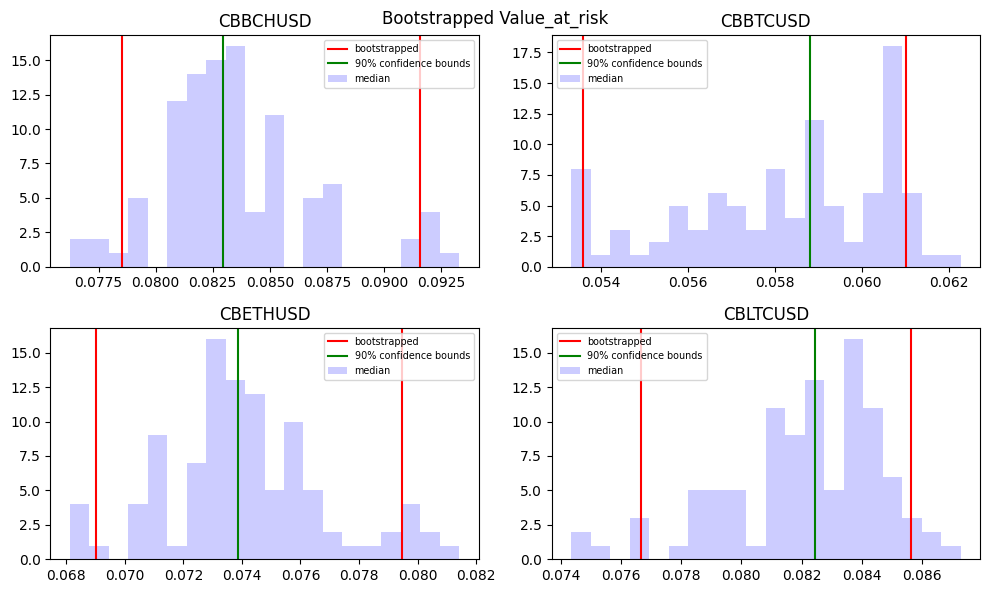

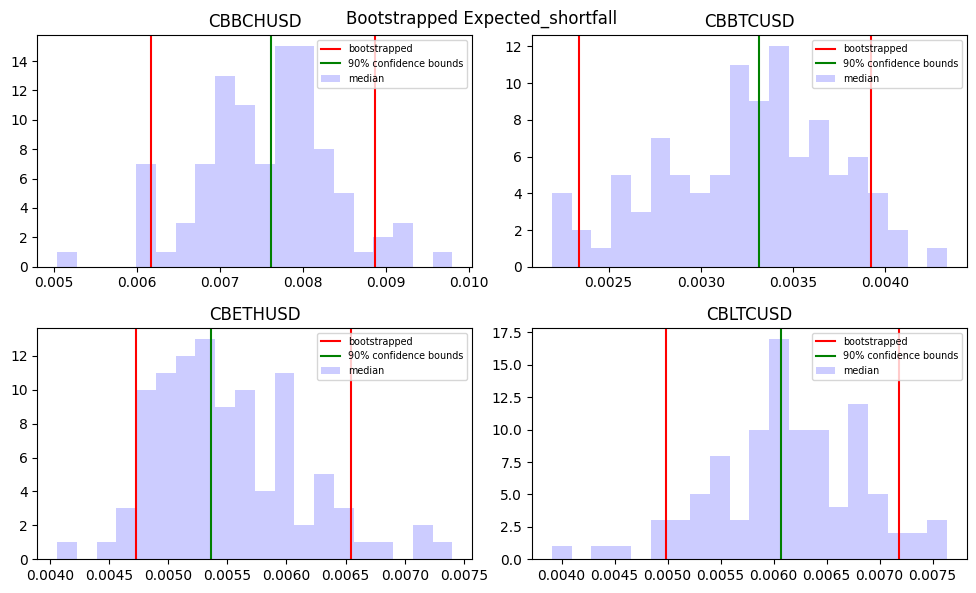

In [45]:
# Run and plot bootstrapped VaR and ES
n = 100
confidence = 0.9
intervals = dict()
for measure in ['value_at_risk', 'expected_shortfall']:
    intervals[measure] = dict()
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    for label, ax in zip(cryptos, axes.flatten()):
        bootstraps = bootstrap_risk(cryptos[label].dropna(), alpha=alpha, n=n)
        interval = confidence_intervals(bootstraps[measure], confidence=confidence)
        intervals[measure][label] = interval.tolist()
        ax.hist(bootstraps[measure], color='blue', alpha=0.2, bins=int(n/5))
        ax.axvline(x=interval[0], color='red')
        ax.axvline(x=interval[1], color='green')
        ax.legend(['bootstrapped', f"{confidence*100:.0f}% confidence bounds",
                   'median'], fontsize='x-small')
        ax.axvline(x=interval[2], color='red')
        ax.set_title(label)
    plt.tight_layout()
    plt.suptitle('Bootstrapped ' + measure.capitalize())

In [46]:
# display confidence intervals of VaR
DataFrame(intervals['value_at_risk'], index=['lower', 'median', 'upper'])\
    .rename_axis(index='Value at Risk')

,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
Value at Risk,,,,
lower,0.078517,0.053589,0.069026,0.076687
median,0.082939,0.058818,0.073875,0.082435
upper,0.091576,0.061019,0.079481,0.085629


In [47]:
# display confidence intervals of VaR
DataFrame(intervals['expected_shortfall'], index=['lower', 'median', 'upper'])\
    .rename_axis(index='Expected Shortfall')

,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
Expected Shortfall,,,,
lower,0.006168,0.002339,0.004729,0.004981
median,0.007616,0.003314,0.005362,0.006072
upper,0.008870,0.003924,0.006546,0.007182


## Conditional volatility models

A return distribution’s characteristics may change over time. A mixture model of normal distributions with varying volatilities produces more peakedness and fatter tails than a simple normal distribution. 
In a model where returns re conditionally normal, the distribution is normal each day, while the standard deviation of the return varies over time. This leads to an unconditional distribution with fat tails.

### EWMA model

Volatility can be estimated using an equal-weighted moving average of squared returns. However, this method suffers from sudden jumps when large returns enter or exit the dataset.  

The **Exponentially Weighted Moving Average (EWMA)** model addresses this by applying exponentially decreasing weights to past returns:  

$$
\sigma^2_t = (1 - \lambda) r^2_{t-1} + \lambda \sigma^2_{t-1}
$$

where $ \lambda $ is a positive value less than 1 which determines the decay rate of past observations. This formula provides a very simple way of implementing EWMA. The new estimate of the variance rate on day $t$ is a weighted average of the estimate of the variance rate made for the previous day $t - 1$, and
the most recent observation of the squared return on day $t - 1$. In the 1990s, JP Morgan's **RiskMetrics** suggests $ \lambda = 0.94 $ for daily market volatility estimation. 





In [48]:
# Estimate EWMA (lambda=0.94) rolling model predictions for all cryptos
lambda_ = 0.94
ewma = {label: np.sqrt((cryptos[label]**2).dropna().ewm(alpha=1-lambda_).mean())
        for label in cryptos}

In [49]:
# Helper to plot predicted VaR vs actual returns
def plot_var(X: Series, VaR: Series, ax: plt.Axes):
    """Helper to plot returns and VaR predictions"""
    ax.plot(X, ls='', marker='.', markersize=2)
    ax.plot(-VaR.shift(-1), lw=1, ls='-', c='r')
    ax.plot(VaR.shift(-1), lw=1, ls='-', c='r')
    ax.legend([X.name, 'VaR', '$-$VaR'])

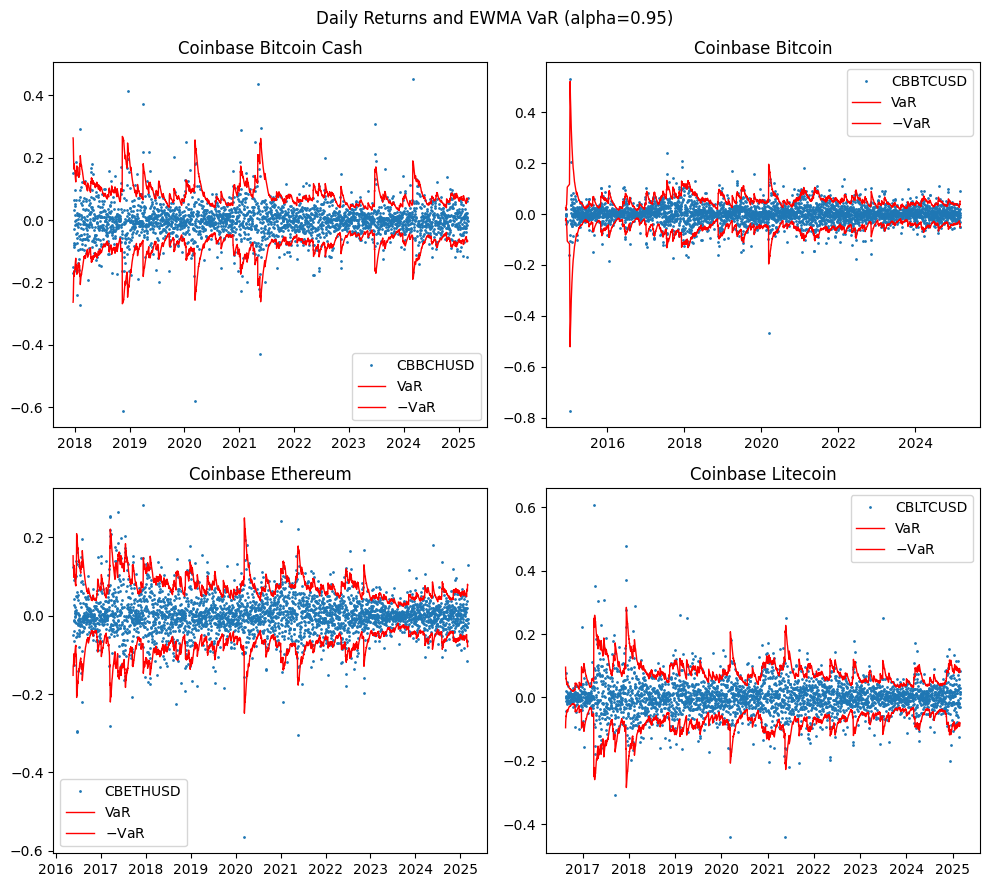

In [50]:
# Plot daily returns and EWMA predicted VaR of all cryptos
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    Z = pd.concat([cryptos[label].dropna(),
                   parametric_risk(ewma[label], alpha=alpha)['value_at_risk']\
                   .rename('VaR')],
                  join='inner', axis=1).dropna()
    plot_var(Z[label], VaR=Z['VaR'], ax=ax)
    ax.set_title(titles[label])
plt.suptitle(f"Daily Returns and EWMA VaR (alpha={alpha})")
plt.tight_layout()

In [51]:
# Properties of EWMA normalized returns for all cryptos
ewma_hist = dict()
for label in cryptos:
    X = (cryptos[label] / ewma[label].shift(-1))  # normalize by predict vol
    ewma_hist[label] = Series(historical_risk(X, alpha=0.95)).rename(label)
print("Normalized by EWMA predicted volatility (alpha=0.95)")
DataFrame(ewma_hist).round(4)

Normalized by EWMA predicted volatility (alpha=0.95)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
N,2622.0000,3708.0000,3206.0000,3116.0000
value_at_risk,1.5056,1.4695,1.5831,1.5697
expected_shortfall,0.1241,0.0717,0.0828,0.0896
volatility,0.9269,0.9252,0.9432,0.9425
skewness,0.1035,-0.0464,-0.0177,0.0048
excess_kurtosis,-1.5298,-1.5609,-2.1157,-1.8466
jb_statistic,240.8139,321.2816,104.6335,172.7197
jb_pvalue,0.0000,0.0000,0.0000,0.0000


### GARCH model

The **Generalized Autoregressive Conditional Heteroskedasticity (GARCH)** model, developed by Robert Engel and Tim Bollerslev, can be intuitively regarded as an extension of EWMA. In **GARCH (1,1)**, we also give some weight to a long run average variance $\hat{\sigma}$.

$$
\sigma^2_t = \alpha r^2_{t-1} + \beta \sigma^2_{t-1} + \gamma \hat{\sigma}
$$

where $ \alpha + \beta + \gamma = 1 $. This introduces **mean reversion**, where the $\hat{\sigma}$ term provides a “pull” toward the long-run average, ensuring that volatility stabilizes over time. And just as with ARMA specifications of time series models, more complex **GARCH(p,q)** models can incorporate additional lags of $q$ squared returns and $p$ variance estimates for improved accuracy.  


__rugarch package in R__

In [52]:
# Estimate GARCH(1, 1) by calling R's rugarch library
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.utils import PyR
def rugarch(X: Series, savefig: str = '', verbose=VERBOSE) -> Series:
    """GARCH(1,1) wrapper over rugarch"""
    rugarch_ro = importr('rugarch')  # to use library rugarch
    c_ = ro.r['c']
    list_ = ro.r['list']
    spec = ro.r['ugarchspec'](mean_model=list_(armaOrder=c_(0,0), include_mean=False))
    model = ro.r['ugarchfit'](spec, data=PyR(X.values).ro)
    if verbose:
        ro.r['show'](model)
    if savefig:
        for which in [4, 5, 10, 11]:
            ro.r['plot'](model, which=which)
            PyR.savefig(f"{savefig}{which}.png", display=None)
    return Series(PyR(ro.r['sigma'](model)).values.flatten(),
                  index=X.index, name=X.name)

In [53]:
# Estimate GARCH(1,1) full period model for all cryptos
garch = {label: rugarch(cryptos[label].dropna()) for label in cryptos}

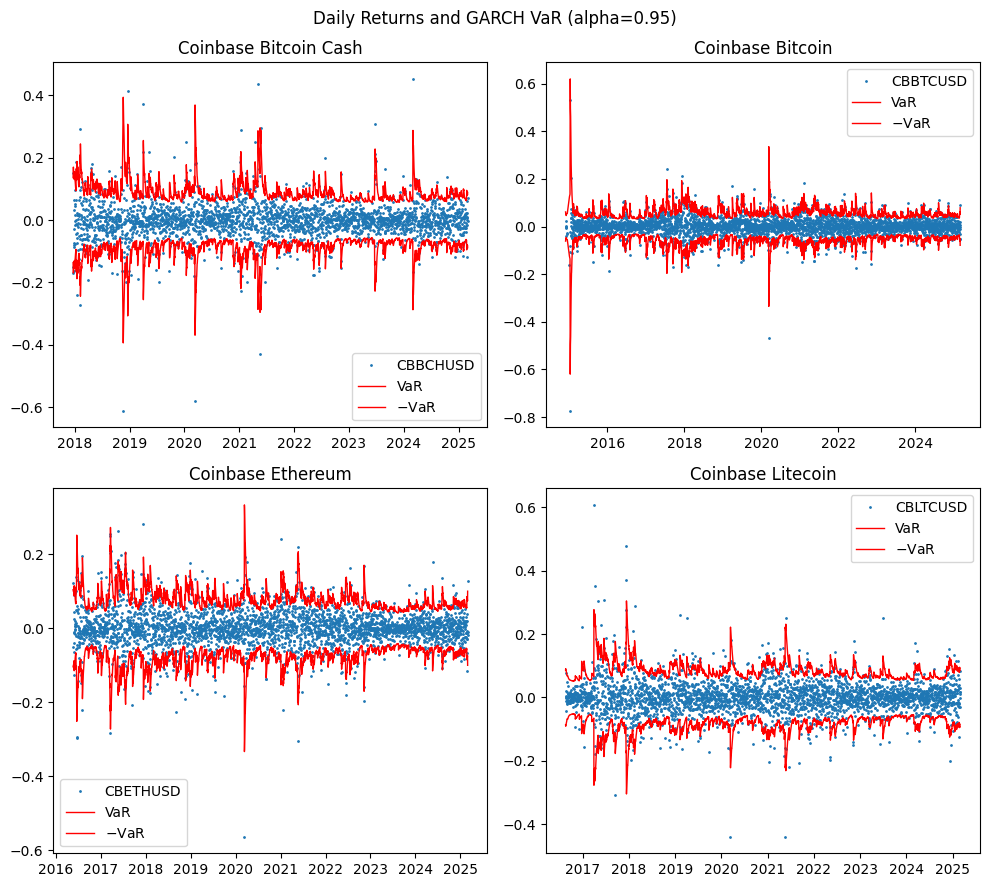

In [54]:
# Plot daily returns and GARCH predicted VaR
alpha = 0.95   # VaR parameter
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
for label, ax in zip(cryptos, axes.flatten()):
    Z = pd.concat([cryptos[label],
                   parametric_risk(garch[label], alpha=alpha)['value_at_risk']\
                   .rename('VaR')],
                  join='inner', axis=1).dropna()
    plot_var(Z[label], VaR=Z['VaR'], ax=ax)
    ax.set_title(titles[label])
plt.suptitle(f"Daily Returns and GARCH VaR (alpha={alpha})")
plt.tight_layout()

In [55]:
# Properties of GARCH normalized returns
garch_hist = dict()
for label in cryptos:
    X = (cryptos[label] / garch[label].shift(-1))  # normalize by predict vol
    garch_hist[label] = Series(historical_risk(X, alpha=0.95)).rename(label)
print("Normalized by GARCH predicted volatility (alpha=0.95)")
DataFrame(garch_hist).round(4)

Normalized by GARCH predicted volatility (alpha=0.95)


,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
N,2622.0000,3708.0000,3206.0000,3116.0000
value_at_risk,1.3382,1.2965,1.4123,1.3956
expected_shortfall,0.1062,0.0504,0.0789,0.0843
volatility,0.7901,0.7740,0.8411,0.8454
skewness,0.0185,-0.0364,-0.0033,0.0350
excess_kurtosis,-2.5903,-2.9028,-2.7553,-1.9190
jb_statistic,18.4912,2.2795,8.0058,152.3519
jb_pvalue,0.0001,0.3199,0.0183,0.0000


## Backtesting VaR

The simplest method for validating a VaR model is failure rate analysis, which counts the proportion of times actual losses exceed the VaR estimate. If the model is accurate, these exceedances should follow a binomial distribution with probability $ p = 1 - \alpha $, where $\alpha$ is the VaR confidence level.  The VaR model can be rejected in two regions, both when the number of observed violations is too few or too many. 


### Kupiec Likelihood Ratio test

Kupiec (1995) proposed a likelihood ratio test for backtesting VaR based on the number of observed violations:  
$$LR = -2 [(N - S) \ln(1 - p) + S \ln(p)] + 2 [(N - S) \ln(1 - S/N) + S \ln(S/N)]  $$

where $ S $ is the number of VaR exceedances in $ N $ observations.  

In [56]:
def kupiec_LR(alpha: float, s: int, n: int):
    """Compute Kupiec likelihood ratio given s violations in n trials

    Returns:
        Dict of likelihood statistic and pvalue
    """
    p = 1 - alpha       # prob of violation
    num = np.log(1 - p)*(n - s) + np.log(p)*s
    den = np.log(1 - (s/n))*(n - s) + np.log(s/n)*s
    lr = -2 * (num - den)
    return {'lr': lr, 'violations': s, 'N': n,
            # '5%_critical': stats.chi2.ppf(0.95, df=1),
            'pvalue': 1 - stats.chi2.cdf(lr, df=1)}

In [57]:
def kupiec(X: Series, VaR: Series, alpha: float) -> Dict:
    """Kupiec Likelihood Ratio test of VaR

    Returns:
        Dict of likelihood statistic and pvalue
    """
    Z = pd.concat([X, VaR], axis=1).dropna()
    n = len(Z)
    s = np.sum(Z.iloc[:, 0] < -Z.iloc[:, 1])  # number of violations < -VaR
    return kupiec_LR(alpha=alpha, s=s, n=n)

In [58]:
# Kupiec likelihood ratio test for EWMA
row_formatted(DataFrame(
    {label: kupiec(cryptos[label],
                   VaR=parametric_risk(ewma[label], alpha=alpha)['value_at_risk'],
                   alpha=alpha) for label in cryptos})\
              .rename_axis(index=f"EWMA({lambda_})", columns="Kupiec LR Test:").round(4),
              {'N': '{:.0f}', 'violations': '{:.0f}'})

Kupiec LR Test:,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
EWMA(0.94),,,,
lr,1.9136,3.8477,1.3918,3.0693
violations,116,160,146,135
N,2623,3709,3207,3117
pvalue,0.1666,0.0498,0.2381,0.0798


In [59]:
# Kupiec likelihood ratio test for GARCH(1,1)
row_formatted(DataFrame(
    {label: kupiec(cryptos[label],
                   VaR=parametric_risk(garch[label], alpha=alpha)['value_at_risk'],
                   alpha=alpha) for label in cryptos})\
              .rename_axis(index=f"GARCH(1,1)", columns="Kupiec LR Test:").round(4),
              {'N': '{:.0f}', 'violations': '{:.0f}'})

Kupiec LR Test:,CBBCHUSD,CBBTCUSD,CBETHUSD,CBLTCUSD
"GARCH(1,1)",,,,
lr,6.8446,5.5607,3.4345,12.3497
violations,103,155,138,115
N,2623,3709,3207,3117
pvalue,0.0089,0.0184,0.0638,0.0004


### Conditional coverage tests

Value-at-Risk (VaR) violations should occur randomly over time; if violations cluster, it may suggest that the model is misspecified. Conditional coverage tests, which extend Kupiec’s test, evaluate not only the frequency but also the independence of exceptions over time.


In [60]:
# TODO: conditional likelihood test


**References:**

Jorion, Phillippe. Value at Risk.

P. Artzner, F. Delbaen, J.-M. Eber, and D. Heath, "Coherent Measures of Risk", Mathematical Finance 9 (1999): 203–228.

Kupiec, P. (1995). Techniques for Verifying the Accuracy of Risk Measurement Models. Journal of Derivatives, 3, 73-84.

FRM Part I Exam Book Ch. 1-3

FRM Part II Exam Book Market Risk Measurement and Management Ch. 1-2